In [351]:
#!/usr/bin/env python

# make sure to install these packages before running:
# pip install pandas
# pip install sodapy

import pandas as pd
from sodapy import Socrata

# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
client = Socrata("data.cityofchicago.org", None)

# Example authenticated client (needed for non-public datasets):
# client = Socrata(data.cityofchicago.org,
#                  MyAppToken,
#                  userame="user@example.com",
#                  password="AFakePassword")



In [352]:
# First 2000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
rlc_cam = client.get("spqx-js37", #speed cams are at 'hhkd-xvj4' 
                     #where='violation_date > 01-01-2020',
                     where='violation_date BETWEEN \'2015-01-01T00:00:00.000\' AND \'2020-12-20T00:00:00.000\'',
                     limit=1000000,
                    )

# Convert to pandas DataFrame
results_df = pd.DataFrame.from_records(rlc_cam)

In [353]:
from datetime import datetime
results_df.info()
results_df['violations'] = results_df['violations'].apply(int)
results_df['latitude'] = results_df['latitude'].apply(float)
results_df['longitude'] = results_df['longitude'].apply(float)
results_df['violation_date'] = pd.to_datetime(results_df['violation_date'])
results_df['month'] = results_df['violation_date'].apply(lambda x: x.month)
results_df['weekday'] = results_df['violation_date'].apply(lambda x: datetime.weekday(x))
results_df['year'] = results_df['violation_date'].apply(lambda x: x.year)


results_df.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568314 entries, 0 to 568313
Data columns (total 10 columns):
intersection      568314 non-null object
camera_id         568080 non-null object
address           568314 non-null object
violation_date    568314 non-null object
violations        568314 non-null object
x_coordinate      538698 non-null object
y_coordinate      538698 non-null object
latitude          538698 non-null object
longitude         538698 non-null object
location          538698 non-null object
dtypes: object(10)
memory usage: 43.4+ MB


intersection camera_id                address violation_date  \
568309    CANAL AND ROOSEVELT      2291    1200 S CANAL STREET     2020-12-14   
568310      KOSTNER AND NORTH      2011         1600 N KOSTNER     2020-12-14   
568311  LARAMIE AND FULLERTON      1421  2400 N LARAMIE AVENUE     2020-12-14   
568312   MICHIGAN AND JACKSON      3043     100 E JACKSON BLVD     2020-12-14   
568313  PULASKI AND FULLERTON      1484   4000 W FULLERTON AVE     2020-12-14   

        violations       x_coordinate       y_coordinate   latitude  \
568309           5  1173268.771030949  1894952.634878732  41.867175   
568310           1  1146732.108679105  1910282.120990798  41.909788   
568311           2  1141282.877477884  1915479.163971956  41.924152   
568312           3  1177358.427851268  1899073.064228489  41.878390   
568313           4  1149303.081963737  1915695.275222648  41.924593   

        longitude                                           location  month  \
568309 -87.639376  {'latitude': '41.86717512472001', 'longitude':...     12   
568310 -87.736405  {'latitude': '41.90978830394343', 'longitude':...     12   
568311 -87.756295  {'latitude': '41.92415187425276', 'longitude':...     12   
568312 -87.624237  {'latitude': '41.87839012377354', 'longitude':...     12   
568313 -87.726819  {'latitude': '41.92459302175305', 'longitude':...     12   

        weekday  year  
568309        0  2020  
568310        0  2020  
568311        0  2020  
568312        0  2020  
568313        0  2020

In [354]:
import plotly.express as px



df_plot = results_df.groupby(['camera_id', 'intersection', 'latitude', 'longitude', 'address'], as_index=True)['violations'].sum().reset_index()
print(df_plot.head())
df_plot['lat'] = df_plot['latitude'].apply(lambda x: '{:.2f}'.format(x))
df_plot['long'] = df_plot['longitude'].apply(lambda x: '{:.2f}'.format(x))



# fig = px.scatter_geo(results_df.groupby('camera_id').sum(), locations="iso_alpha",
#                      color="violations", # which column to use to set the color of markers
#                      #hover_name="country", # column added to hover information
#                      size="violations", # size of markers
#                      projection="natural earth")

#px.scatter_mapbox?
fig = px.scatter_mapbox(df_plot, 
                        lat="latitude", 
                        lon="longitude", 
                        color="violations",
                        hover_name='intersection',
                        size='violations',
                        #label=['lat','long','violations'],
                        color_continuous_scale='BlueRed', 
                        #range_color=[range_min, range],
                        #center={'lat':41.975605, 'lon': -87.731670},
                        zoom=9.5,
                        opacity=0.6,
                        height=700,
                        hover_data={'camera_id':False, 'lat':False, 'long':':.2f', 'latitude':False} ,
                       )

fig.update_layout(mapbox_style="stamen-toner")  #, hoverlabel={}. MAYBE??
#fig.update_layout (textposition='top left', textfont_size=40)

#fig.update_layout(mapbox_style="open-street-map", height=800)

fig.show()


  camera_id                  intersection   latitude  longitude  \
0      1002            WESTERN AND CERMAK  41.851984 -87.685786   
1      1003            WESTERN AND CERMAK  41.852141 -87.685753   
2      1011          PETERSON AND WESTERN  41.990586 -87.689822   
3      1014          PETERSON AND WESTERN  41.990609 -87.689735   
4      1023  IRVING PARK AND NARRAGANSETT  41.953025 -87.786683   

                 address  violations  
0  2200 S WESTERN AVENUE        9821  
1     2400 W CERMAK ROAD        3416  
2     6000 N WESTERN AVE        7424  
3        2400 W PETERSON       14214  
4       6400 W IRVING PK        4733  


In [355]:
import plotly.express as px



df_plot = results_df.groupby(['weekday', 'latitude', 'longitude', 'month', 'address'])['violations'].sum().reset_index()
#weekday_dfs = []
#for i in range(7):
#    weekday_dfs.append(df_plot = results_df[results_df['weekday']==i])


# fig = px.scatter_geo(results_df.groupby('camera_id').sum(), locations="iso_alpha",
#                      color="violations", # which column to use to set the color of markers
#                      #hover_name="country", # column added to hover information
#                      size="violations", # size of markers
#                      projection="natural earth")

#px.scatter_mapbox?

fig = px.scatter_mapbox(df_plot, 
                        lat="latitude", 
                        lon="longitude", 
                        color="violations",
                        #text='address',
                        animation_frame='weekday',
                        size='violations',
                        hover_name='address',
                        labels=['violations', 'latitude', 'longitude'],
                        color_continuous_scale='Plotly3', 
                        #range_color=[1000, 20000],
                        #center={'lat':41.975605, 'lon': -87.731670},
                        zoom=9.5,
                        opacity=0.6,
                        
                       )
#fig.update_layout(mapbox_style="stamen-toner")
fig.update_layout(mapbox_style="open-street-map", height=800)

fig.show()

   weekday  violations
0        0      426540
1        1      427473
2        2      435813
3        3      456795
4        4      501553
   weekday   latitude  longitude  month          address  violations
0        0  41.677721 -87.642052      1  11900 S HALSTED         168
1        0  41.677721 -87.642052      2  11900 S HALSTED         142
2        0  41.677721 -87.642052      3  11900 S HALSTED         168
3        0  41.677721 -87.642052      4  11900 S HALSTED         148
4        0  41.677721 -87.642052      5  11900 S HALSTED         175
   weekday   latitude  longitude  month          address  violations
0        0  41.677721 -87.642052      1  11900 S HALSTED         168
1        0  41.677721 -87.642052      2  11900 S HALSTED         142
2        0  41.677721 -87.642052      3  11900 S HALSTED         168
3        0  41.677721 -87.642052      4  11900 S HALSTED         148
4        0  41.677721 -87.642052      5  11900 S HALSTED         175


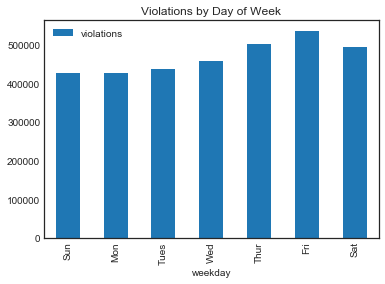

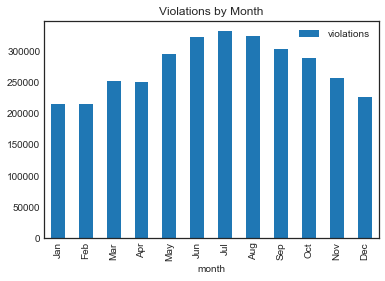

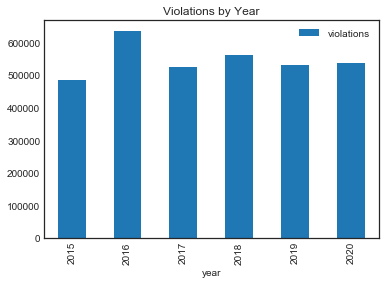

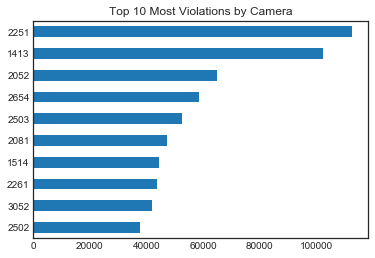

<Figure size 720x576 with 0 Axes>

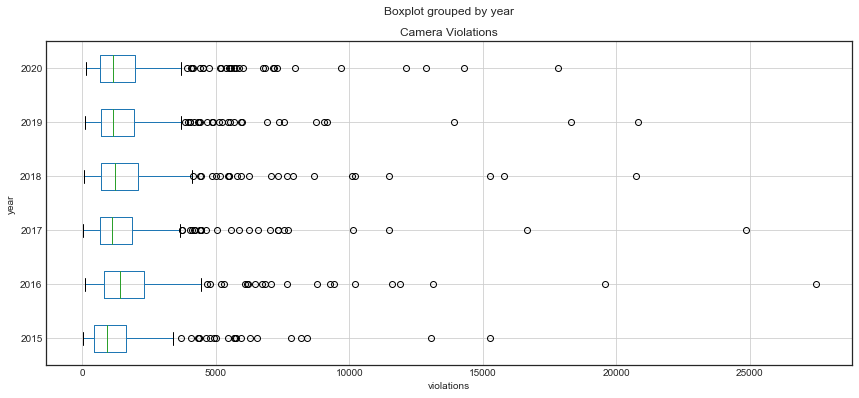

In [356]:
import matplotlib.pyplot as plt
pd.options.plotting.backend = "matplotlib"


plt.style.use('seaborn-white')


# Weekday plot
df_weekday = results_df.groupby(['weekday'])['violations'].sum().reset_index()
print(df_weekday.head())


ax = df_weekday.plot.bar('weekday', 'violations')
labels = ['Sun', 'Mon', 'Tues', 'Wed', 'Thur', 'Fri', 'Sat']
ax.set_xticklabels(labels)
ax.set_title("Violations by Day of Week")
plt.plot()

# Month plot
df_month = results_df.groupby(['month'])['violations'].sum().reset_index()
print(df_plot.head())

ax2 = df_month.plot.bar('month', 'violations')
labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
ax2.set_xticklabels(labels)
ax2.set_title("Violations by Month")
plt.plot()

# Year plot
df_year = results_df.groupby(['year'])['violations'].sum().reset_index()
print(df_plot.head())

ax4 = df_year.plot.bar('year', 'violations')
ax4.set_title("Violations by Year")


# top 10 plot
df_top10 = results_df.groupby(['camera_id'])['violations'].sum().reset_index()
df_top10 = df_top10.sort_values(['violations'], ascending=True).tail(10)
ax3 = df_top10.plot.barh(y='violations', x='camera_id')

ax3.set_title("Top 10 Most Violations by Camera")
ax3.set_ylabel('') # post plot, you have to talk to y, even in a barh
ax3.get_legend().remove()

plt.show()# box plot all cameras

plt.figure(figsize=[10,8])
#results_df.groupby(['camera_id'])['violations'].sum().reset_index().boxplot('violations')
#results_df.groupby(['year', 'camera_id']).sum().reset_index().boxplot(by='year')

#results_df.groupbyboxplot(column=['SepalLength'], by='Name', ax=ax)
results_df.groupby(['year', 'camera_id']).sum().reset_index()[['year', 'violations']].boxplot(by='year', vert=False, figsize=[14,6])
plt.xlabel('violations')
plt.ylabel('year')
plt.title('Camera Violations')
plt.show()

# print(results_df['year'].unique())


In [357]:
# basic pd info
print('All Data')
print(results_df['violations'].describe())

print('\n'*2 + 'Weekday Grouped Violations')
print(df_weekday['violations'].describe())

print('\n'*2 + 'Weekday Grouped Violations')
print(df_month['violations'].describe())


All Data
count    568314.000000
mean          5.767678
std           7.472297
min           1.000000
25%           2.000000
50%           4.000000
75%           7.000000
max         186.000000
Name: violations, dtype: float64


Weekday Grouped Violations
count         7.000000
mean     468264.571429
std       42617.930666
min      426540.000000
25%      431643.000000
50%      456795.000000
75%      497817.500000
max      535596.000000
Name: violations, dtype: float64


Weekday Grouped Violations
count        12.000000
mean     273154.333333
std       42898.553536
min      214455.000000
25%      244136.000000
50%      272032.500000
75%      307600.750000
max      331496.000000
Name: violations, dtype: float64


In [358]:
# !pip install plotly==4.1.1
# !pip install plotly-express==0.4.0

In [359]:
results_df['year'].unique()

array([2015, 2016, 2017, 2018, 2019, 2020])

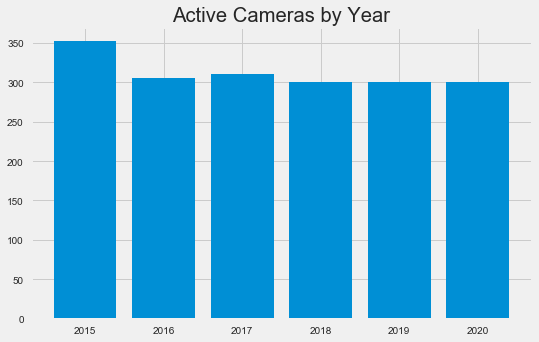

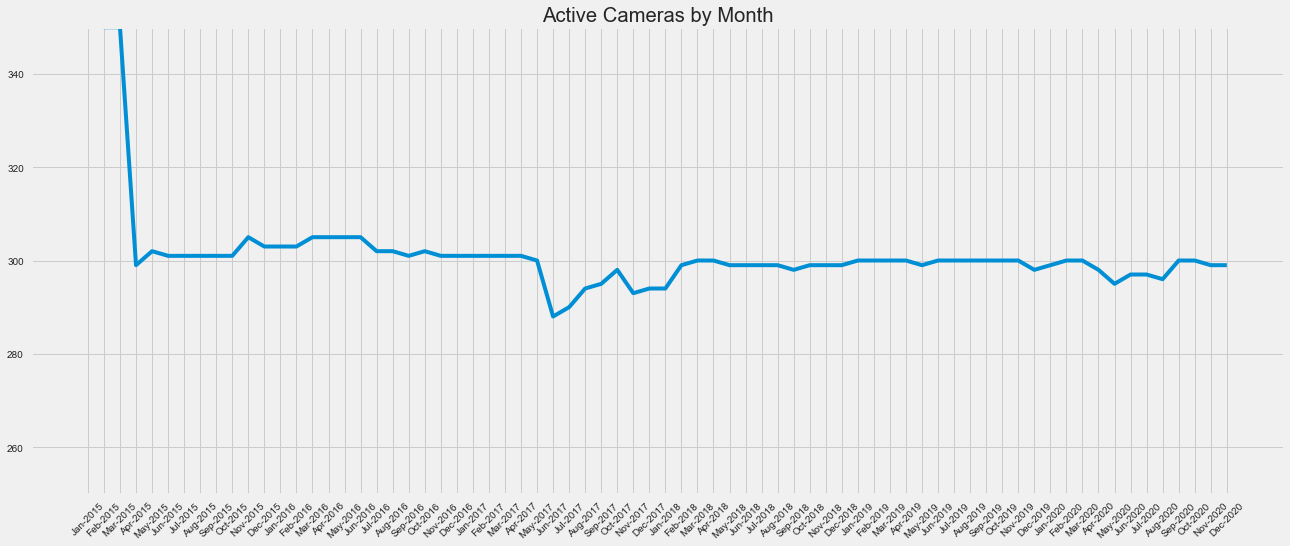

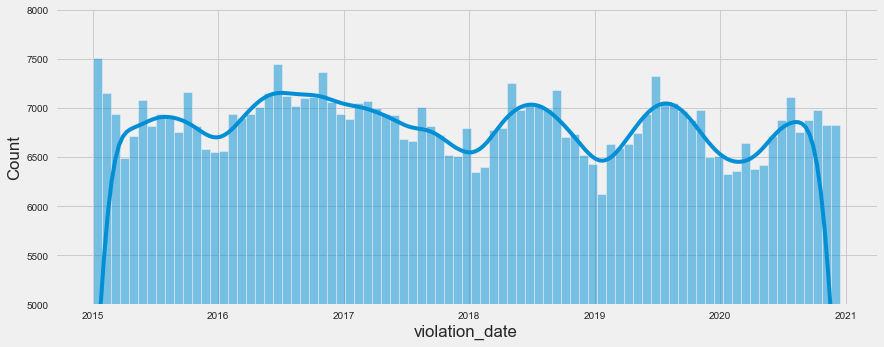

In [538]:
# how many rlc do we have by year.  Let's find out when they were OFF
import seaborn as sns
plt.style.use('fivethirtyeight')

#print(results_df.groupby(['camera_id', 'year']).count().reset_index())
# how many in 2017?
year_cams = []
for year in range(2015, 2021):
    year_cams.append([year, len(results_df[results_df['year']==year].groupby('camera_id').count().reset_index())])
year_cams = np.array(year_cams)

plt.figure(figsize=[8,5])
plt.bar(year_cams[:,0], year_cams[:,1])
plt.title("Active Cameras by Year")
plt.show()

# lets look at a closer timeline of n cameras
month_cams = []
months = 'JanFebMarAprMayJunJulAugSepOctNovDec'
for y in range(2015, 2021):
    for m in range(1,13):
        month_cams.append([months[(m-1)*3:m*3] + "-" + str(y),
                               len(results_df[(results_df['year']==y) & (results_df['month']==m)]
                                .groupby('camera_id')
                                .count()
                                .reset_index())])
month_cams = np.array(month_cams)

plt.figure(figsize=[20,8])
plt.plot([x for x in range(len(month_cams[:,1]))], month_cams[:,1].astype(np.int))
plt.xticks([x for x in range(len(month_cams[:,1]))], month_cams[:,0], rotation=45)

plt.title("Active Cameras by Month")
plt.ylim(250, 350)
plt.show()


# Now do violations per month
sns.displot(results_df['violation_date'], kde=True, height=5, aspect=2.5)
plt.ylim(5000, 8000)
plt.show()


Looks like we had a bunch removed in 2015, and maybe some added at same time.  Thats our experiment.  
Question!!!  What are the start and end dates for each camera??? Probably need to look at each year and catch the start and end date, then label our 50+ cameras for our natural experiment.  We might not have a ton of data to work from.

Proposal:  Crashes were not recorded until 2015.  It wasn't fully mandatroy until Sept 2017 which unfortuantely is where the data is reliable.  However, we can go through every camera from 2015 to 2020 and look at the earliest date and latest date we have in the dataset.  That informs us when the camera went live or when it was shut down.  Reporting was by precinct.  The precinct is in the crash data  

Note:  In EDA, I see a lot of down time on cameras which will mess us up.  It's probably maintenance/road work/malfunction etc.  Probably need to do a check to see when camera is down.  Maybe just look at consecutive days of zero fines (maybe look as SD along with it).  Consecutive zeros can be chopped out of the dataset, or better yet... just fill in the mean for those dates.

In [62]:
# pickle my data to prevent more queries
# import pickle


# with open('all_data.pkl', 'wb') as f:
#     pickle.dump(results_df, f)


    

In [156]:
# let's bring in our data now
import pickle
import pandas as pd


with open('all_data.pkl', 'rb') as f:
    results_df = pickle.load(f)
    
results_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 566286 entries, 0 to 566285
Data columns (total 13 columns):
intersection      566286 non-null object
camera_id         566052 non-null object
address           566286 non-null object
violation_date    566286 non-null datetime64[ns]
violations        566286 non-null int64
x_coordinate      536766 non-null object
y_coordinate      536766 non-null object
latitude          536766 non-null float64
longitude         536766 non-null float64
location          536766 non-null object
month             566286 non-null int64
weekday           566286 non-null int64
year              566286 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(4), object(6)
memory usage: 56.2+ MB


In [157]:
cam_list = results_df['camera_id'].unique()


In [158]:
len(cam_list)  # we have 364 total.  That's interesting.  There are some short lived cameras in there.

364

In [361]:
# let's see if we can look at one camera and determine first and last date
# def min_date(my_df, cam_id):
#     start = results_df[results_df['camera_id']==cam_list[i]]['violation_date'].min()
#     #my_df['start'].apply(lambda x: )
#     return start

results_df['start'] = results_df['camera_id'].apply(lambda x: None)
results_df['end'] = results_df['camera_id'].apply(lambda x: None)
#results_df['camera_id'] = results_df['camera_id'].apply(lambda x: int(x))

    
#results_df.head()


In [362]:
#for cam in cam_list:
    #start = results_df[results_df['camera_id']==cam_list[i]]['violation_date'].min()
    #end = results_df[results_df['camera_id']==cam_list[i]]['violation_date'].max()
    #results_df.iloc['camera_id']['start'] = results_df.loc[results_df['camera_id']==cam]['start'] = start
    #results_df.loc[results_df['camera_id']==cam]['end'] = end

#start = results_df[results_df['camera_id']==cam_list[i]]['violation_date'].min()
#results_df = results_df.iloc[:100, :]

print('converting')
results_df['violation_date'] = pd.to_datetime(results_df['violation_date'])

cam_start = results_df.groupby(['camera_id'])['violation_date'].min().reset_index()
cam_end = results_df.groupby(['camera_id'])['violation_date'].max().reset_index()

cam_startend = cam_start.copy()
#print(cam_end[cam_end['camera_id']=='1503'].values[0][1])
cam_startend['end'] = cam_start['camera_id'].apply(lambda x: cam_end[cam_end['camera_id']==x].values[0][1])


#print("START")
#results_df['start'] = results_df['camera_id'].apply(lambda x: cam_start[cam_start['camera_id']==x])['violation_date']

#print('END')
#results_df['end'] = results_df['camera_id'].apply(lambda x: cam_end[cam_end['camera_id']==x][:])

#results_df.head(100)

cam_startend.rename(columns={"violation_date": "start"}, inplace=True)

                                                    
cam_startend.head()

converting


camera_id      start        end
0      1002 2015-01-01 2020-12-14
1      1003 2015-01-01 2020-12-14
2      1011 2015-01-02 2020-12-14
3      1014 2015-01-01 2020-12-14
4      1023 2015-01-02 2020-12-14

In [363]:
#import timeit

# def get_max(df, cam_id):
#     my_max = df[df['camera_id']==cam_id].max()['violation_date']
#     return my_max



# get_max(cam_end, '1503')


# _results_df = results_df.iloc[:100, :]


# # Trying out some possible ways to builde the start end dates into my df
# results_df['end'] = results_df['camera_id'].apply(lambda x: get_max(cam_end, x))

# results_df.head()

In [364]:

def get_minmax(df, cam_id, which):
    if which == 'start':
        return(df[df['camera_id']==cam_id]['start'].values[0])
    else:
        return(df[df['camera_id']==cam_id]['end'].values[0])

print(get_minmax(cam_startend, '1002', 'start'))

print(cam_startend.head())


2015-01-01T00:00:00.000000000
  camera_id      start        end
0      1002 2015-01-01 2020-12-14
1      1003 2015-01-01 2020-12-14
2      1011 2015-01-02 2020-12-14
3      1014 2015-01-01 2020-12-14
4      1023 2015-01-02 2020-12-14


In [365]:
results_df.isna().sum()
results_df = results_df[results_df['camera_id'].notna()]
results_df.isna().sum()

intersection           0
camera_id              0
address                0
violation_date         0
violations             0
x_coordinate       29603
y_coordinate       29603
latitude           29603
longitude          29603
location           29603
month                  0
weekday                0
year                   0
start             568080
end               568080
dtype: int64

In [438]:
def transform_location(x):
    if type(x) == tuple:
        return x
    else:
        return (float(x['latitude']), float(x['longitude']))

results_df['location'] = results_df['location'].apply(transform_location)
results_df.tail(50)

intersection camera_id                 address  \
568264          LAKE AND UPPER WACKER      3052   340 W UPPER WACKER DR   
568265              ARCHER AND CICERO      2081       5200 S CICERO AVE   
568266                KEDZIE AND 63RD      2361       6300 S KEDZIE AVE   
568267            ASHLAND AND MADISON      1911         0 N ASHLAND AVE   
568268             PULASKI AND ARCHER      2154       5000 S ARCHER AVE   
568269            CENTRAL AND CHICAGO      1972    800 N CENTRAL AVENUE   
568270  STONY ISLAND/CORNELL AND 67TH      2721   6700 S STONY ISLAND A   
568271            CICERO AND HARRISON      2022     600 S CICERO AVENUE   
568272                 CICERO AND I55      2251    4200 S CICERO AVENUE   
568273               ASHLAND AND 87TH      2452      8700 S ASHLAND AVE   
568274           ASHLAND AND LAWRENCE      1142   4800 N ASHLAND AVENUE   
568275             ELSTON AND ADDISON      1403       3216 W ADDISON ST   
568276               WESTERN AND 63RD      2373          2400 W 63RD ST   
568277          ROOSEVELT AND HALSTED      2234    800 W ROOSEVELT ROAD   
568278               55TH AND WESTERN      2212      5500 S WESTERN AVE   
568279                RIDGE AND CLARK      1051     5930 N CLARK STREET   
568280              111TH AND HALSTED      2424          800 W 111TH ST   
568281           CORTLAND AND ASHLAND      1721      1900 N ASHLAND AVE   
568282               55TH and PULASKI      2242          5500 S PULASKI   
568283              TOUHY AND OSCEOLA      1243     7432 W TOUHY AVENUE   
568284         HOLLYWOOD AND SHERIDAN      1343    1000 W HOLLYWOOD AVE   
568285            PULASKI AND BELMONT      1382       3200 N PULASKI RD   
568286            SHERIDAN AND FOSTER      1132    5200 N SHERIDAN ROAD   
568287      LAKE SHORE DR AND BELMONT      1412   3200 N LAKESHORE DRIV   
568288                 STATE AND 79TH      2654         1 E 79TH STREET   
568289               PULASKI AND 79TH      2492     7900 S PULASKI ROAD   
568290           PULASKI AND ARMITAGE      1843  4000 W ARMITAGE AVENUE   
568291             BELMONT AND KEDZIE      1371    3200 N KEDZIE AVENUE   
568292            CICERO AND ARMITAGE      2003  4800 W ARMITAGE AVENUE   
568293               CICERO AND NORTH      2033     4800 W NORTH AVENUE   
568294            CICERO AND PETERSON      1202    6000 N CICERO AVENUE   
568295           PULASKI AND DIVISION      1802     1200 N PULASKI ROAD   
568296              PULASKI AND NORTH      1994     4000 W NORTH AVENUE   
568297         HOLLYWOOD AND SHERIDAN      1344    1000 W HOLLYWOOD AVE   
568298        CALIFORNIA AND DIVERSEY      1513         2800 W DIVERSEY   
568299                KEDZIE AND 47TH      2104          3200 W 47TH ST   
568300               JEFFERY AND 95TH      2522      9500 S JEFFERY AVE   
568301            KEDZIE AND ARMITAGE      1834  3200 W ARMITAGE AVENUE   
568302               ASHLAND AND 87TH      2454          1600 W 87TH ST   
568303                KEDZIE AND 71ST      2352    7100 S KEDZIE AVENUE   
568304                KEDZIE AND 31ST      2132    3100 S KEDZIE AVENUE   
568305          ROOSEVELT AND HALSTED      2233    800 W ROOSEVELT ROAD   
568306              HALSTED AND NORTH      1761   1600 N HALSTED STREET   
568307      LAKE SHORE DR AND BELMONT      1413       400 W BELMONT AVE   
568308             HARLEM AND BELMONT      1391       3200 N HARLEM AVE   
568309            CANAL AND ROOSEVELT      2291     1200 S CANAL STREET   
568310              KOSTNER AND NORTH      2011          1600 N KOSTNER   
568311          LARAMIE AND FULLERTON      1421   2400 N LARAMIE AVENUE   
568312           MICHIGAN AND JACKSON      3043      100 E JACKSON BLVD   
568313          PULASKI AND FULLERTON      1484    4000 W FULLERTON AVE   

       violation_date  violations       x_coordinate       y_coordinate  \
568264     2020-12-14          27                NaN                NaN   
568265     2020-12-14           8  1145195.931989

In [457]:
# this will be a dict for all of the intersections we look up.  We have fewer intersections than cams
used_ints = {}  # for next part.  Only want to do this once.  There is a limit on geocode usage from geopy.


In [459]:
'''
This section goes through all of the rlc and assigns latlong
Many lights are missing it.  
For each light, there is an address though.
We use geocoding to get the latlong

10min runtime
'''


# let's also get all of the red light cameras with their gps location.  
# This will aid in placing the accidents at rlc intersections later (if closer than threshold point to point)
# Some RLCs are missing location data,  but have addresses.  I can use geocoding I guess to look them up.

from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="https://github.com/sciencelee/chicago_rlc")


#location = geolocator.geocode("175 5th Avenue NYC")
#print(location.address)
# out: Flatiron Building, 175, 5th Avenue, Flatiron, New York, NYC, New York, ...

#print((location.latitude, location.longitude))
# out: (40.7410861, -73.9896297241625)

#print(location.raw)
# out: {'place_id': '9167009604', 'type': 'attraction', ...}


# CAN USE THIS TO FIGURE OUT MY LAT LONG FROM RLC ADDRESS (or crash)


address_fix = {'2400 W VAN BUREN STREE': '2400 W VAN BUREN STREET',
               '4700 W IRVING PARK ROA': '4700 W IRVING PARK ROAD',
               '11500 S HALSTED STREE': '11500 S HALSTED STREET',
               '5500 S WENTWORTH AVEN': '5500 S WENTWORTH AVENUE',
                '10300 S HALSTED STREE': '10300 S HALSTED STREET',
               '3700 W IRVING PARK ROA': '3700 W IRVING PARK ROAD',
               '1600 W IRVING PARK ROA': '1600 W IRVING PARK ROAD',
               '7900 S JEFFERY BOULEV': '7900 S JEFFERY BOULEVARD',
               '2800 W IRVING PARK ROA': '2800 W IRVING PARK ROAD',
               '5200 W IRVING PARK ROA': '5200 W IRVING PARK ROAD',
               '3100 S DR MARTIN L KING': '3100 S MARTIN KING DRIVE',
               '1600 W DIVERSEY PARKWA': '1600 W DIVERSEY PARKWAY',
               '140 W KINZIE': '140 W Kinzie St',
                '150 N SACRAMENTO BOUL': '150 N SACRAMENTO BOUL',
               '800 N SACRAMENTO AVEN':'800 N SACRAMENTO AVENUE',
               '3200 N LAKESHORE DRIV':'3200 N LAKE SHORE DRIVE',
               '6400 W FULLERTON AVENU':'6400 W FULLERTON AVENUE',
               '6400 N MILWAUKEE AVEN':'6400 N MILWAUKEE AVENUE',
               '7900 S STONEY ISLAND':'7900 S Stony Island Ave',  
               '150 N SACRAMENTO BOUL':'150 N SACRAMENTO BOULEVARD',
                '3200 N LAKESHORE DRIVE':'3200 N Lake Shore Dr',
               '7900 S STONEY ISLAND AVENUE':'7900 S Stony Island Ave',
               '5600 W FULLERTON AVENU':'5600 W FULLERTON AVENUE',
               '8700 S LAFAYETTE AVEN':'8700 S LAFAYETTE AVENUE',
               '4400 N MILWAUKEE AVEN':'4400 N MILWAUKEE AVENUE',
              }

# def get_geocode(address, cam_id, intersection):
#     if address in address_fix.keys(): address = address_fix[address]  # errors in the dataset chars omitted

#     if address in used_addresses:
#         return used_addresses[address]
    
#     location = geolocator.geocode(address + ', Chicago, IL')
#     if location == None:
#         print(address+':'+address+',')
#     else:
#         used_addresses[address] = [(location.latitude, location.longitude), cam_id, intersection]
#         return (location.latitude, location.longitude)

# TRY 2.  Getting geocode errors.  Would like to stick with location, unless necessary
def get_geocode(orig_loc, address, cam_id, intersection):
    if type(orig_loc)==float:  # it's not a tuple, and has no location
        if address in address_fix.keys(): address = address_fix[address]  # errors in the dataset chars omitted

        if intersection in used_ints: 
            if cam_id not in used_ints[intersection][1]: # then add it
                used_ints[intersection][1].append(cam_id)
            return used_ints[intersection][0]  # if we have already seen this one just return loc

        # if we make it this far, we have no record of this cam_id yet, and it doesn't have a proper location
        location = geolocator.geocode(address + ', Chicago, IL')
        if location == None:
            print(address+':'+address+' : could not geolocate') # print it out if we can't find (address errors)
        else:
            used_ints[intersection] = [(location.latitude, location.longitude), [cam_id], intersection]
            #print('Geocode lookup:', intersection)
            return (location.latitude, location.longitude)
    
    else: # it's a proper location tuple, and assumed to be correct latlong
        #print("orig_loc:", orig_loc, intersection)
        if intersection in used_ints:
            # it's already in our dictionary, let's see if we have looked at this cam yet.
            if cam_id not in used_ints[intersection][1]: 
                used_ints[intersection][1].append(cam_id)
            return used_ints[intersection][0]
        
        # then it's a new one, so let's make a new dict entry for this intersection
        used_ints[intersection] = [orig_loc, [cam_id], intersection]
        return (float(orig_loc[0]), float(orig_loc[1]))


#print(results_df.columns)
#print(results_df.loc[1,'address'])
#results_df['location'] = results_df['address'].apply(get_geocode)

# there is a clean one liner in python for this, I just know it.  Experiment here.
results_df['location'] = results_df.apply(lambda x: get_geocode(x.location, x.address, x.camera_id, x.intersection), axis=1)

# some test code...
# for i in range(50):
#     x=results_df.iloc[i]
#     print('BEFORE', x.location, x.camera_id)
#     print('AFTER', get_geocode(x.location, 
#                       x.address, 
#                       x.camera_id, 
#                       x.intersection))
    
print(used_ints)

{'31ST ST AND MARTIN LUTHER KING DRIVE': [(41.7802309, -87.6156396), ['2121', '2123'], '31ST ST AND MARTIN LUTHER KING DRIVE'], 'ASHLAND AND DIVERSEY': [(41.932484, -87.668562), ['1623', '1621'], 'ASHLAND AND DIVERSEY'], 'IRVING PARK AND LARAMIE': [(41.9538663, -87.7166086), ['1533', '1534'], 'IRVING PARK AND LARAMIE'], 'ELSTON AND IRVING PARK': [(41.953838, -87.720427), ['1503', '1502'], 'ELSTON AND IRVING PARK'], 'IRVING PARK AND KILPATRICK': [(41.9538663, -87.7166086), ['2764', '2763'], 'IRVING PARK AND KILPATRICK'], 'IRVING PARK AND CALIFORNIA': [(41.9538663, -87.7166086), ['1234', '1233'], 'IRVING PARK AND CALIFORNIA'], 'HALSTED AND 103RD': [(41.7067555, -87.64313360938277), ['2592', '2593'], 'HALSTED AND 103RD'], 'JEFFERY AND 79TH': [(41.751481, -87.576088), ['2662', '2663'], 'JEFFERY AND 79TH'], 'VAN BUREN AND WESTERN': [(41.876162, -87.686438), ['2054', '2052'], 'VAN BUREN AND WESTERN'], 'HOMAN/KIMBALL AND NORTH': [(41.9099165, -87.7119101), ['1771', '1773'], 'HOMAN/KIMBALL AND

In [460]:
results_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 568080 entries, 0 to 568313
Data columns (total 15 columns):
intersection      568080 non-null object
camera_id         568080 non-null object
address           568080 non-null object
violation_date    568080 non-null datetime64[ns]
violations        568080 non-null int64
x_coordinate      538477 non-null object
y_coordinate      538477 non-null object
latitude          538477 non-null float64
longitude         538477 non-null float64
location          568080 non-null object
month             568080 non-null int64
weekday           568080 non-null int64
year              568080 non-null int64
start             0 non-null object
end               0 non-null object
dtypes: datetime64[ns](1), float64(2), int64(4), object(8)
memory usage: 69.3+ MB


In [539]:
print(results_df.head())
#results_df['latitude'] = results_df['location'].apply(lambda x: x[0])
#results_df['longitude'] = results_df['location'].apply(lambda x: x[1])


cam_startend.iloc[0]

tryme = results_df.iloc[:10]
#print(tryme)

cam_startend[cam_startend['camera_id']=='2763']['start']

#tryme['camera_id'].apply(lambda x: cam_startend[cam_startend['camera_id']==x][1])
cam_startend.info()

# len(cam_startend.camera_id)
# len(cam_startend.camera_id.unique())

                           intersection camera_id                  address  \
0  31ST ST AND MARTIN LUTHER KING DRIVE      2121  3100 S DR MARTIN L KING   
1                  ASHLAND AND DIVERSEY      1623   1600 W DIVERSEY PARKWA   
2               IRVING PARK AND LARAMIE      1533   5200 W IRVING PARK ROA   
3                ELSTON AND IRVING PARK      1503   3700 W IRVING PARK ROA   
4            IRVING PARK AND KILPATRICK      2764   4700 W IRVING PARK ROA   

  violation_date  violations x_coordinate y_coordinate  latitude  longitude  \
0     2015-01-01          19          NaN          NaN       NaN        NaN   
1     2015-01-01           2          NaN          NaN       NaN        NaN   
2     2015-01-01           2          NaN          NaN       NaN        NaN   
3     2015-01-01           2          NaN          NaN       NaN        NaN   
4     2015-01-01           3          NaN          NaN       NaN        NaN   

                    location  month  weekday  year start

In [462]:
# pickle my data so I don't have to run all that again.
# We have a limit on geopy uses per day.
# This should set us up for being done with red light stuff, and moving on to crash data|

with open('used_ints.pkl', 'wb') as f:
    pickle.dump(used_ints, f)

# with open('used_cams.pkl', 'wb') as f:
#     pickle.dump(used_cams, f)

# with open('all_data.pkl', 'wb') as f:
#     pickle.dump(results_df, f)
    
# let's bring in our used_addresses now
# import pickle
# import pandas as pd


with open('used_ints.pkl', 'rb') as f:
    used_ints = pickle.load(f)




print(used_ints)
# print(len(used_addresses))
# print(len(results_df['camera_id'].unique()))

{'31ST ST AND MARTIN LUTHER KING DRIVE': [(41.7802309, -87.6156396), ['2121', '2123'], '31ST ST AND MARTIN LUTHER KING DRIVE'], 'ASHLAND AND DIVERSEY': [(41.932484, -87.668562), ['1623', '1621'], 'ASHLAND AND DIVERSEY'], 'IRVING PARK AND LARAMIE': [(41.9538663, -87.7166086), ['1533', '1534'], 'IRVING PARK AND LARAMIE'], 'ELSTON AND IRVING PARK': [(41.953838, -87.720427), ['1503', '1502'], 'ELSTON AND IRVING PARK'], 'IRVING PARK AND KILPATRICK': [(41.9538663, -87.7166086), ['2764', '2763'], 'IRVING PARK AND KILPATRICK'], 'IRVING PARK AND CALIFORNIA': [(41.9538663, -87.7166086), ['1234', '1233'], 'IRVING PARK AND CALIFORNIA'], 'HALSTED AND 103RD': [(41.7067555, -87.64313360938277), ['2592', '2593'], 'HALSTED AND 103RD'], 'JEFFERY AND 79TH': [(41.751481, -87.576088), ['2662', '2663'], 'JEFFERY AND 79TH'], 'VAN BUREN AND WESTERN': [(41.876162, -87.686438), ['2054', '2052'], 'VAN BUREN AND WESTERN'], 'HOMAN/KIMBALL AND NORTH': [(41.9099165, -87.7119101), ['1771', '1773'], 'HOMAN/KIMBALL AND

In [444]:
results_df.head(50)

intersection camera_id                  address  \
0   31ST ST AND MARTIN LUTHER KING DRIVE      2121  3100 S DR MARTIN L KING   
1                   ASHLAND AND DIVERSEY      1623   1600 W DIVERSEY PARKWA   
2                IRVING PARK AND LARAMIE      1533   5200 W IRVING PARK ROA   
3                 ELSTON AND IRVING PARK      1503   3700 W IRVING PARK ROA   
4             IRVING PARK AND KILPATRICK      2764   4700 W IRVING PARK ROA   
5             IRVING PARK AND CALIFORNIA      1234   2800 W IRVING PARK ROA   
6                      HALSTED AND 103RD      2592    10300 S HALSTED STREE   
7                       JEFFERY AND 79TH      2662    7900 S JEFFERY BOULEV   
8             IRVING PARK AND KILPATRICK      2763   4700 W IRVING PARK ROA   
9                  VAN BUREN AND WESTERN      2054   2400 W VAN BUREN STREE   
10               HOMAN/KIMBALL AND NORTH      1771      1600 N HOMAN AVENUE   
11                     115TH AND HALSTED      2552    11500 S HALSTED STREE   
12               ASHLAND AND IRVING PARK      1153   1600 W IRVING PARK ROA   
13            IRVING PARK AND CALIFORNIA      1233   2800 W IRVING PARK ROA   
14                WENTWORTH AND GARFIELD      2261    5500 S WENTWORTH AVEN   
15                  KIMBALL AND DIVERSEY      1581    2800 N KIMBALL AVENUE   
16                95TH AND STONEY ISLAND      2514       1600 E 95TH STREET   
17                  HALSTED AND DIVISION      1711           1200 N HALSTED   
18                     ARCHER AND CICERO      2084        5400 S ARCHER AVE   
19                   MADISON AND WESTERN      1934           2400 W MADISON   
20                95TH AND STONEY ISLAND      2513       1600 E 95TH STREET   
21                    GRAND AND OAK PARK      1523      6800 W GRAND AVENUE   
22                 WESTERN AND MARQUETTE      2674    2400 W MARQUETTE ROAD   
23                   KIMBALL AND LINCOLN      2741    6200 N KIMBALL AVENUE   
24                       79TH AND KEDZIE      2442        7900 S KEDZIE AVE   
25                   LAWRENCE AND CICERO      1041        4800 N CICERO AVE   
26                       KEDZIE AND 47TH      2101        4700 S KEDZIE AVE   
27               CALIFORNIA AND DIVERSEY      1511    2800 N CALIFORNIA AVE   
28          ARCHER/NARRAGANSETT AND 55TH      2073        6400 W ARCHER AVE   
29                COTTAGE GROVE AND 95TH      2602     9500 S COTTAGE GROVE   
30                      PULASKI AND 79TH      2494       4000 W 79TH STREET   
31                   PULASKI AND CHICAGO      1982       800 N PULASKI ROAD   
32                      WESTERN AND 63RD      2371       6300 S WESTERN AVE   
33                    GRAND AND OAK PARK      1524      6800 W GRAND AVENUE   
34                 PULASKI AND FULLERTON      1481        2400 N PULASKI RD   
35                 PULASKI AND FULLERTON      1484     4000 W FULLERTON AVE   
36                 BLUE ISLAND AND DAMEN      2281      2416 S DAMEN AVENUE   
37                   LAWRENCE AND CICERO      1042     4800 N CICERO AVENUE   
38                  ASHLAND AND DIVISION      1793   1600 W DIVISION STREET   
39                  GARFIELD AND ASHLAND      2274     1600 W GARFIELD BLVD   
40                       RIDGE AND CLARK      1052      5930 N CLARK STREET   
41                SACRAMENTO AND CHICAGO      1812    800 N SACRAMENTO AVEN   
42          ARCHER/NARRAGANSETT AND 55TH      2074        6400 W ARCHER AVE   
43                   MADISON AND CENTRAL      1754    5600 W MADISON STREET   
44                   CICERO AND DIVERSEY      1691     2800 N CICERO AVENUE   
45                       RIDGE AND CLARK      1051      5930 N CLARK STREET   
46                      PULASKI AND 79TH      2492      7900 S PULASKI ROAD   
47                   HALSTED AND MADISON      1872       1 N HALSTED STREET   
48                 ROOSEVELT AND KOSTNER      2323         4400 W ROOSEVELT   
49               CALIFORNIA AND PETERSON      1313   2800 W PETERSON AVENUE   

In [540]:
cam_start[cam_start['camera_id']=='2763']['violation_date'].values[0]

numpy.datetime64('2015-01-01T00:00:00.000000000')

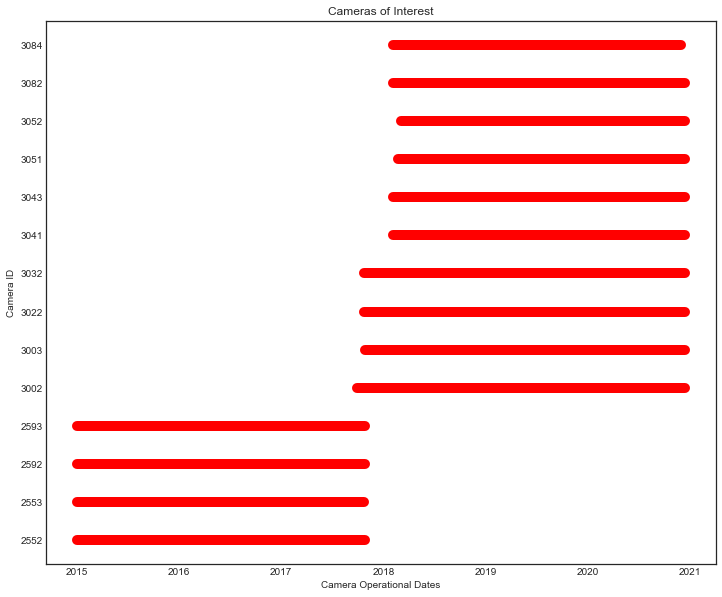

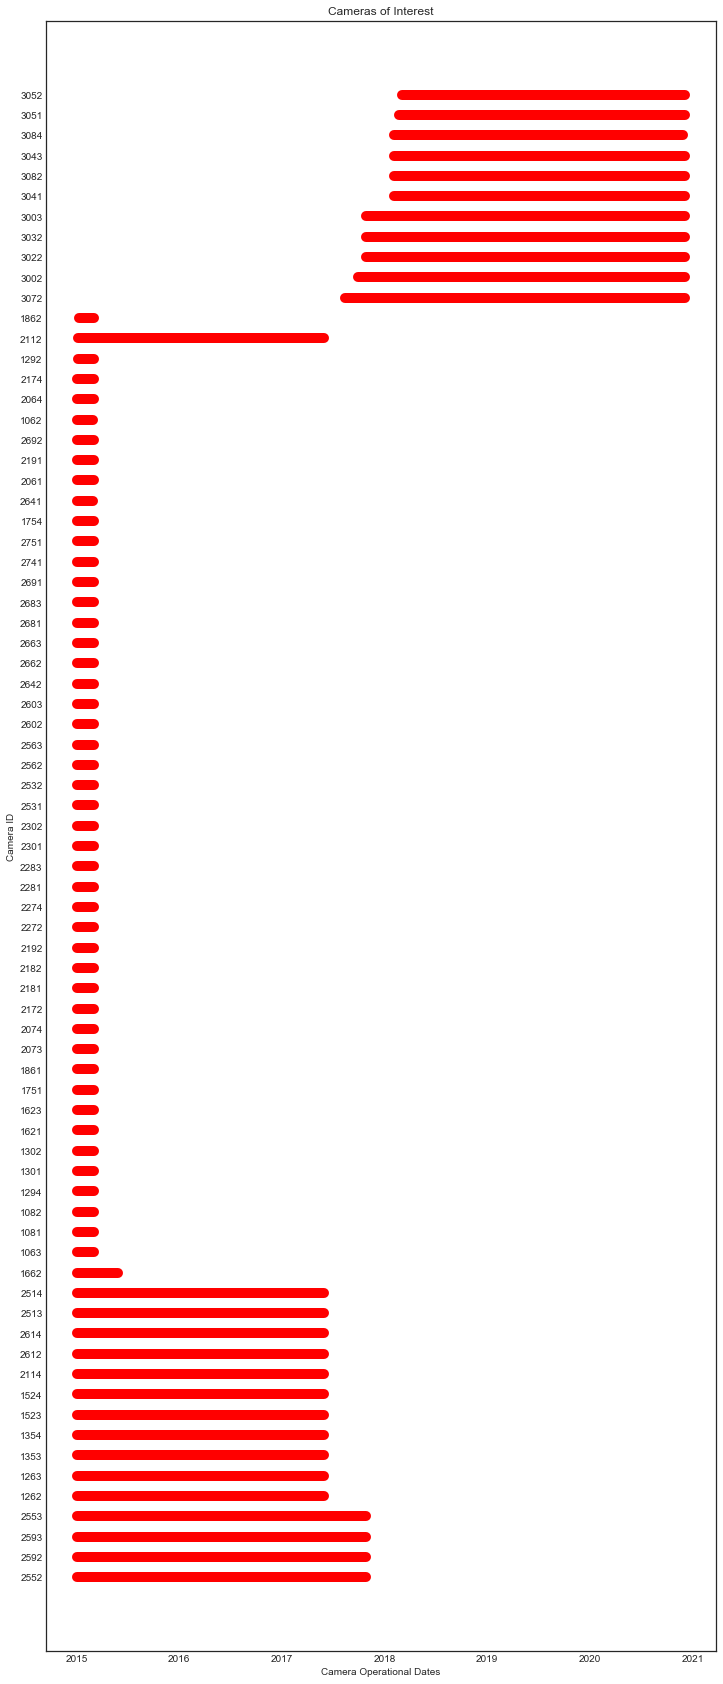

In [468]:
import numpy as np
import matplotlib.pyplot as plt
from dateutil import parser
#parser.parse("Aug 28 1999 12:00AM")

start = cam_ends['start'].min()
end = cam_ends['end'].max()
x = np.arange(start, end, dtype='datetime64[D]')
cam_ends.sort_values(by=['start', 'end'], ascending=[True, False], inplace=True)
my_start_date = '2017-09-01'  # can also use '2017-09-01' for reporting requirment

# plot and grab ids for all cams that were installed during timeframe 2017 through current that edned or started
# during the same time
plt.figure(figsize=[12,10])
cams_of_interest = []
for i in range(len(cam_ends)):
    cam = cam_startend.iloc[i]
    if (cam['start'] > parser.parse(my_start_date) or parser.parse(my_start_date) < cam['end'] < parser.parse('2020-10-01')):
        #print(cam[1], "PARSED", parser.parse('2015-04-01'))
        cams_of_interest.append(cam['camera_id'])
        plt.plot([cam[1], cam[2]], [cam[0], cam[0]], linewidth=10, linestyle='-', color='red')
    
plt.title('Cameras of Interest')
plt.ylabel('Camera ID')
plt.xlabel('Camera Operational Dates')
plt.show()


# we may choose to go all the way back to beginning of 2015 when we began recording accidents.
# some precincts did not fully comply until sept 2017 though
cams_of_interest2 = []
plt.figure(figsize=[12,30])

for i in range(len(cam_ends)):
    cam = cam_ends.iloc[i]
    if (cam[2] > parser.parse('2015-02-01') or parser.parse('2015-02-01') < cam[1] < parser.parse('2020-10-01')):
        #print(cam[1], "PARSED", parser.parse('2015-04-01'))
        cams_of_interest2.append(cam[0])
        plt.plot([cam[1], cam[2]], [cam[0], cam[0]], linewidth=10, linestyle='-', color='red')
    
plt.title('Cameras of Interest')
plt.ylabel('Camera ID')
plt.xlabel('Camera Operational Dates')
plt.show()

In [463]:
print('Cameras turned on or off during crash reporting:', len(cams_of_interest))
print('Cameras turned on or off during partial crash reporting:', len(cams_of_interest2))


Cameras turned on or off during crash reporting: 14
Cameras turned on or off during partial crash reporting: 74


In [448]:
print(cams_of_interest)

['2552', '2553', '2592', '2593', '3002', '3003', '3022', '3032', '3041', '3043', '3051', '3052', '3082', '3084']


In [ ]:
# I would like to add start end dates to my intersections as well

In [450]:
# now we need to figure out what those intersections are and the relative time dates for each


interest_df = results_df[results_df['camera_id'].isin(cams_of_interest)]

print(len(interest_df))
# we have 13k accidents with these cams, so maybe enough to do AB test or something

interest_df = interest_df[interest_df['violation_date'] > parser.parse('01-09-17')]

print(len(interest_df))
# after filtering out the ones that were before accurate reporting, we are sadly down to ~10k 

13401
10709


In [93]:
interest_df.columns

Index(['intersection', 'camera_id', 'address', 'violation_date', 'violations',
       'x_coordinate', 'y_coordinate', 'latitude', 'longitude', 'location',
       'month', 'weekday', 'year'],
      dtype='object')

In [94]:
# NEED DATA TO SEND FOR NATURAL EXPERIMENT


interest_df.info()
interest_df.longitude.unique()
interest_df.latitude.unique()
interest_df['location'].head()


# clean up my new dataset to be consistendt with locations
cam_address_loc = []

for cam in cams_of_interest:
    address = interest_df[interest_df['camera_id'] == cam]['address'].max()
    intersection = interest_df[interest_df['camera_id'] == cam]['intersection'].max()

    cam_address_loc.append([cam, address, intersection])
    

cam_address_loc

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10659 entries, 48 to 566773
Data columns (total 13 columns):
intersection      10659 non-null object
camera_id         10659 non-null object
address           10659 non-null object
violation_date    10659 non-null datetime64[ns]
violations        10659 non-null int64
x_coordinate      8093 non-null object
y_coordinate      8093 non-null object
latitude          8093 non-null float64
longitude         8093 non-null float64
location          8093 non-null object
month             10659 non-null int64
weekday           10659 non-null int64
year              10659 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(4), object(6)
memory usage: 1.1+ MB


[['2552', '11500 S HALSTED STREE', '115TH AND HALSTED'],
 ['2592', '10300 S HALSTED STREE', 'HALSTED AND 103RD'],
 ['2593', '800 W 103RD STREET', 'HALSTED AND 103RD'],
 ['2553', '800 W 115TH STREET', '115TH AND HALSTED'],
 ['3002', '5200 N NORTHWEST HWY', 'NORTHWEST HIGHWAY AND FOSTER'],
 ['3022', '5232 N MILWAUKEE AVE', 'MILWAUKEE AND CENTRAL'],
 ['3032', '5232 N CENTRAL AVE', 'CENTRAL AND MILWAUKEE'],
 ['3003', '5616 W FOSTER AVE', 'FOSTER AND NORTHWEST HIGHWAY'],
 ['3041', '300 S MICHIGAN AVE', 'MICHIGAN AND JACKSON'],
 ['3082', '628 N MICHIGAN AVE', 'MICHIGAN AND ONTARIO'],
 ['3043', '100 E JACKSON BLVD', 'MICHIGAN AND JACKSON'],
 ['3084', '100 E ONTARIO ST', 'MICHIGAN AND ONTARIO'],
 ['3051', '200 N UPPER WACKER DR', 'LAKE AND UPPER WACKER'],
 ['3052', '340 W UPPER WACKER DR', 'LAKE AND UPPER WACKER']]

In [95]:
print('Total Cams:', len(results_df.camera_id.unique()))
print()

print('Total Cams of Interest:', len(cams_of_interest))
print('Cams of Interest:', cams_of_interest)
print()

print("Total crashes with na for lat/long:", results_df['location'].isna().sum())
print('Perecentage na for lat/long:', results_df['location'].isna().sum()/len(results_df) * 100)
cams_na = results_df[results_df['location'].isna()]['camera_id'].unique()  # cams that have na values
print('Cams that have na for lat/long:', len(cams_na))
print()
# we are missing the location data for 5% of data


# which cams of interest are also na values?
na_cams_of_interest = []
for cam in cams_na:
    if cam in cams_of_interest:
        if cam not in na_cams_of_interest:
            na_cams_of_interest.append(cam)

print("These {} cams of interest have no location values: {}".format(len(na_cams_of_interest), na_cams_of_interest))

# Since my data 'of interest' is sparse, I will add lat/long and while I'm there, I will just add them for all of the cams


Total Cams: 364

Total Cams of Interest: 14
Cams of Interest: ['2552', '2592', '2593', '2553', '3002', '3022', '3032', '3003', '3041', '3082', '3043', '3084', '3051', '3052']

Total crashes with na for lat/long: 29545
Perecentage na for lat/long: 5.2127349876937465
Cams that have na for lat/long: 21

These 4 cams of interest have no location values: ['2552', '2592', '3052', '3051']


In [96]:
cams_na


array(['2763', '2054', '2552', '2764', '1503', '2064', '2261', '1153',
       '1581', '2592', '2662', '1234', '1233', '1771', '1534', '1533',
       '2121', nan, '3052', '3051', '1623'], dtype=object)

In [103]:
results_df.location[1]

nan

In [ ]:
# also need to assign every rlc to a road segment
# we can use this https://stackoverflow.com/questions/24415806/coordinates-of-the-closest-points-of-two-geometries-in-shapely
# https://data.cityofchicago.org/Transportation/Chicago-Traffic-Tracker-Congestion-Estimates-by-Se/n4j6-wkkf
# This has segment ID numbers 1250 of them.
# Segments have start and end lon/lat, we can make into line.  
# rlcs can be points, and shapely has a distance method for finding dist between. Point.distance(Linestring)
# go through all of the Linestrings, then use the min to determine what segment it is on.  
# The segments are more than 300 miles total and are all major surface streets in Chicago
